### Mask country from COSMO-REA6 and alike with rotated grid
Adapted from Jan Keller (2022)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import fiona
from netCDF4 import Dataset
from shapely.geometry import Point, Polygon
import pickle

In [1]:
# read cosmo coordinates
## d=Dataset("/automount/herz/COSMO-REA6/COSMO_REA6_CONST.nc")
d=Dataset("/home/linhho/Documents/Code_PhD/CONST/COSMO_REA6_CONST.nc")
clon=d.variables["var115"][:][0,:,:]
clat=d.variables["var114"][:][0,:,:]

# read coordinates of country shape
# file="/tmp/CNTR_RG_01M_2020_4326.shp"
file="/home/linhho/Documents/Code_PhD/CNTR_RG_01M_2020_4326/CNTR_RG_01M_2020_4326.shp"
for feat in fiona.open(file):
    name=feat["properties"]["NAME_ENGL"]
#     print(name)
    if (name=="Luxembourg"):  ## <<<<<<<<<<<< CHANGE here  !!!!!!!!!!!!!!
        geo=feat["geometry"]
        break

# polys=gpd.read_file("/tmp/CNTR_RG_01M_2020_4326.shp")
polys=gpd.read_file("/home/linhho/Documents/Code_PhD/CNTR_RG_01M_2020_4326/CNTR_RG_01M_2020_4326.shp")
cntrs=polys["geometry"]
cntrs.index=polys.FID

# Minimize search area
xmin=np.where(clon>5)[1][0]
xmax=np.where(clon>16)[1][0]
ymin=np.where(clat>47)[0][0]
ymax=np.where(clat>56)[0][0]

clon2=clon #[ymin:ymax,xmin:xmax]
clat2=clat #[ymin:ymax,xmin:xmax]

# create list of points for cosmo lat and lon
clon2v=clon2.reshape(np.prod(clon2.shape))
clat2v=clat2.reshape(np.prod(clon2.shape))
points=[Point(clon2v[i],clat2v[i]) for i in np.arange(0,len(clon2v))]
pnts = gpd.GeoDataFrame(geometry=points, index=np.arange(0,len(clon2v)))
pnts=pnts.set_crs('epsg:4326')

# get polygon for germany
# cntry=cntrs[cntrs.index.get_level_values("FID")=="DE"]["geometry"]
cntry=cntrs[cntrs.index.get_level_values("FID")=="LU"]#.geometry    ## <<<<<<<<<<< CHANGE here  !!!!!!!!!!

# find grid points in country
geom = cntry.explode()
# mask=pnts.within(geom) # this may take some time (for me: 1 min for germany)

for i in range(len(geom)):
    c=pnts.within(geom[i])
    if i == 0: mask = c
    else:    mask = np.logical_or(mask, c)

# create mask for COSMO-REA6
rea6_mask=np.zeros(clon.shape)
# rea6_mask[ymin:ymax,xmin:xmax]=np.array(mask).reshape(clon2.shape)  # only for Germany
rea6_mask=np.array(mask).reshape(clon2.shape)  # for country in Europe

# save mask
# f=open("/automount/ftp/jkeller/REA6/mask_germany.pckl","wb")
f=open("/home/linhho/Documents/Code_PhD/mask_country_rea6/mask_luxembourg.pckl","wb")    ## <<<<<<<<<<<<< CHANGE here  !!!!!!!!!!!!!
pickle.dump(rea6_mask,f)
f.close()


<ipython-input-1-773abfac13d4>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clon=d.variables["var115"][:][0,:,:]
<ipython-input-1-773abfac13d4>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clat=d.variables["var114"][:][0,:,:]


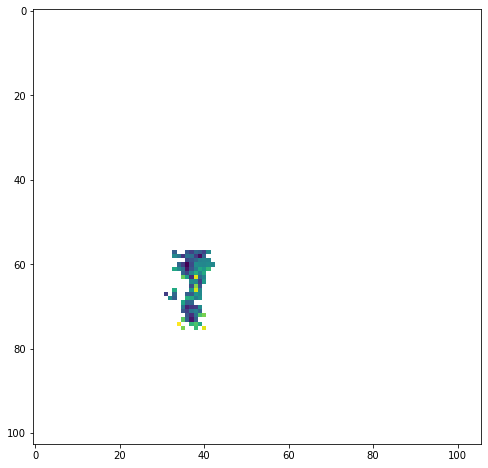

In [3]:
## TEST
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]  # increase size of inline figure

fname = '/home/linhho/Documents/Code_PhD/mask_country_rea6/mask_unitedkingdom2.pckl'
obj = pd.read_pickle(fname)
mask_cnt_rea6 = np.logical_not(obj[::8,::8])

fname = '/net/respos/linhho/energy_model/potential/2017_PV_wind_potential_v2.nc'
ds = xr.open_dataset(fname)
wp_cnt = np.ma.array(ds['Wp'], mask=np.tile(mask_cnt_rea6, (len(ds.time),1,1)))
plt.imshow(np.nansum(wp_cnt, axis=0))

In [113]:
# Dictionary of country code, from shapefile

dict_cnt_code = {"austria" : "AT", "belgium": "BE", "bulgaria": "BG", "croatia": "HR", "cyprus": "CY", "czechia": "CZ", "denmark": "DK", 
                 "estonia": "EE", "finland": "FI", "france": "FR", "germany": "DE", "greece": "GR", "hungary": "HU", "ireland": "IE", 
                 "italy": "IT", "latvia": "LV", "lithuania": "LT", "luxembourg": "LU", "malta": "MT", "netherlands": "NL", 
                 "poland": "PL", "portugal": "PT", "romania": "RO", "slovakia": "SK", "slovenia": "SI", "spain": "ES", "sweden": "SE", "unitedkingdom" : "UK"
                 }
# Austria, Belgium, Bulgaria, Croatia, Cyprus, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, 
# Ireland, Italy, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia, Spain and Sweden
# United Kingdom, Norway

SyntaxError: invalid syntax (<ipython-input-113-2b7404df0f96>, line 5)

Text(30.875, 0.5, 'Latitude')

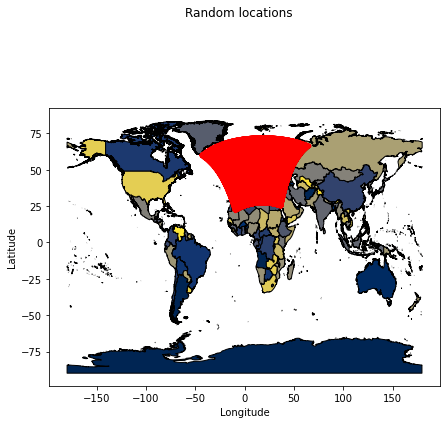

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))

polys.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1,cmap="cividis")


#You can use different 'cmaps' such as jet, plasm,magma, infereno,cividis, binary...(I simply chose cividis)


pnts.plot(ax=ax, color='red', markersize=5);



fig.suptitle('Random locations', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

### Check if the masked data has the shape of that country

In [8]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
fname = '/home/linhho/Documents/Code_PhD/mask_spain.pckl'
obj = pd.read_pickle(fname)
mask_test = np.logical_not(obj[::8,::8])
mask_test

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [75]:
fname = '/net/respos/linhho/energy_model/mean_hourly_1995_2017_PV_wind_generation.nc'
mean_PV_Wp = xr.open_dataset(fname)
mean_PV_Wp
test_mask_test = np.ma.array(mean_PV_Wp['Wp2050'], mask=mask_test)
test_mask_test
plt.imshow(test_mask_test)

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

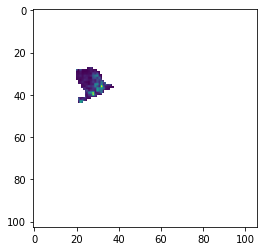

### Calculate time series for that country

In [ ]:
ts_DE_CF = pd.DataFrame(columns=['time', 'PV', 'Wp'])
for year in range(1995,2018):
    print(year)
    fname = '/net/respos/linhho/energy_model/potential/{}_PV_wind_potential_v2.nc'.format(year)
    ds = xr.open_dataset(fname)
    wp_de = np.ma.array(ds['Wp'], mask=np.tile(mask_de, (len(ds.time),1,1)))
    PV_de = np.ma.array(ds['PV'], mask=np.tile(mask_de, (len(ds.time),1,1)))
    ts_wp = np.nansum(wp_de, axis=(1,2))
    ts_pv = np.nansum(PV_de, axis=(1,2))
    tmp = pd.DataFrame({'time': ds['time'],
                     'PV_CF': ts_pv,
                     'Wp_CF': ts_wp,
                     })
    ts_DE_CF = pd.concat([ts_DE_CF, tmp])
ts_DE_CF = ts_DE_CF.reset_index(drop=True)